In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split

import numpy as np
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cpu device


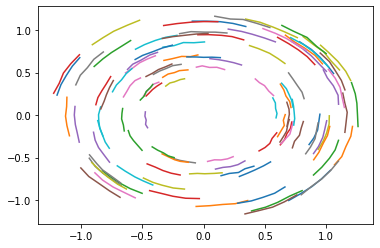

In [2]:
from datasets.mass_spring import getMassSpringTrajectoryDataset

N_traj = 100
traj_length = 5
delta_t = 0.1
H_min = 0.1
H_max = 0.8

sigma = 0.005

trajDataSet = getMassSpringTrajectoryDataset(N_traj, traj_length, delta_t,
                                                     H_min, H_max, sigma)

traj_train_size = 70 * N_traj // 100
traj_test_size = N_traj - traj_train_size


train_trajDataSet, test_trajDataSet = random_split(trajDataSet, [traj_train_size, traj_test_size])


traj_batch_size = 20
train_trajDataLoader = DataLoader(train_trajDataSet, batch_size=traj_batch_size)
test_trajDataLoader = DataLoader(test_trajDataSet, batch_size=traj_batch_size)


z = torch.cat((trajDataSet.x[:,None,:], trajDataSet.y), axis=1)

plt.figure()
plt.plot(z[:,:,0].T, z[:,:,1].T);


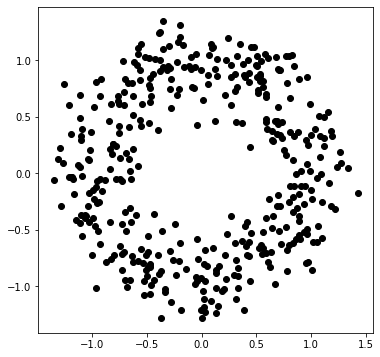

In [3]:
from datasets.mass_spring import getMassSpringVectorFieldDataset

N_samples = 400
H_min = 0.2
H_max = 0.8
sigma = 1e-1


dataset = getMassSpringVectorFieldDataset(N_samples, H_min, H_max, sigma, seed=None)

train_size = 70 * N_samples // 100
test_size = N_samples - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 100

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

plt.figure(figsize=(6,6))
plt.plot(dataset.y[:,0], dataset.y[:,1], 'ko');

In [4]:

from models.hernn import HamiltonianExtendedResidualNeuralNetwork


d = 1
depth = 5
expansion = 10
hrnn_traj_model = HamiltonianExtendedResidualNeuralNetwork(d, depth, expansion, activation=nn.Tanh()).to(device)
print(hrnn_traj_model)

d = 1
depth = 5
expansion = 10
hrnn_vect_model = HamiltonianExtendedResidualNeuralNetwork(d, depth, expansion, activation=nn.Tanh()).to(device)
print(hrnn_vect_model)

from tools.integrate import *
model_int_method = rk4


loss_fn = nn.MSELoss()

wd = 1e-5
hrnn_traj_optimizer = torch.optim.Adam(hrnn_traj_model.parameters(),lr=1e-3, weight_decay=wd)
hrnn_vect_optimizer = torch.optim.Adam(hrnn_vect_model.parameters(),lr=1e-3, weight_decay=wd)

print(hrnn_traj_optimizer)
print(hrnn_vect_optimizer)


HamiltonianExtendedResidualNeuralNetwork(
  (activation): Tanh()
  (linear_layers): ModuleList(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=20, bias=True)
  )
  (linear_to_hamiltonian): Linear(in_features=20, out_features=1, bias=True)
)
HamiltonianExtendedResidualNeuralNetwork(
  (activation): Tanh()
  (linear_layers): ModuleList(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=20, bias=True)
  )
  (linear_to_hamiltonian): Linear(in_features=20, out_features=1, bias=True)
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 1e-05
)
Adam (
Parameter Group 0
    amsgrad: F

In [5]:
from tools.integrate import *
from tools.train import *


traj_epochs = 50
step_size = trajDataSet.pred_times[0]
hrnn_traj_losses = trajectory_train_loop(train_trajDataLoader, test_trajDataLoader, hrnn_traj_model, 
            loss_fn, hrnn_traj_optimizer, traj_epochs, step_size, rk_method=model_int_method, lr=None)

vect_epochs = 50
hrnn_vect_losses = train_loop(train_dataloader, test_dataloader, hrnn_vect_model, loss_fn, 
                                                    hrnn_vect_optimizer, vect_epochs, lr=None)



Epoch   5 / 50 --------- Avg loss: 0.023847
Epoch  10 / 50 --------- Avg loss: 0.013370
Epoch  15 / 50 --------- Avg loss: 0.004742
Epoch  20 / 50 --------- Avg loss: 0.001733
Epoch  25 / 50 --------- Avg loss: 0.001088
Epoch  30 / 50 --------- Avg loss: 0.000744
Epoch  35 / 50 --------- Avg loss: 0.000518
Epoch  40 / 50 --------- Avg loss: 0.000377
Epoch  45 / 50 --------- Avg loss: 0.000279
Epoch  50 / 50 --------- Avg loss: 0.000211

Done!
Epoch   5 / 50 --------- Avg loss: 0.319690
Epoch  10 / 50 --------- Avg loss: 0.159001
Epoch  15 / 50 --------- Avg loss: 0.047858
Epoch  20 / 50 --------- Avg loss: 0.023042
Epoch  25 / 50 --------- Avg loss: 0.016935
Epoch  30 / 50 --------- Avg loss: 0.013538
Epoch  35 / 50 --------- Avg loss: 0.012243
Epoch  40 / 50 --------- Avg loss: 0.011289
Epoch  45 / 50 --------- Avg loss: 0.010784
Epoch  50 / 50 --------- Avg loss: 0.010444

Done!


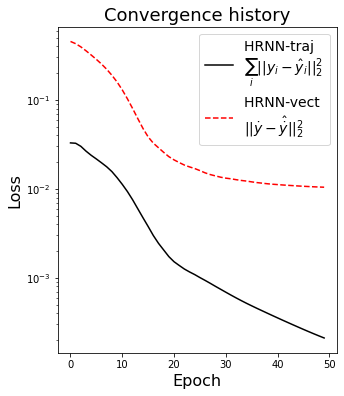

In [27]:

plt.figure(figsize=(5,6))
plt.title("Convergence history", fontsize=18)
plt.semilogy(range(traj_epochs), hrnn_traj_losses, 'k-', label="HRNN-traj \n" + \
                                                               "$\sum_i ||y_i - \hat{y}_i||_2^2$")
plt.semilogy(range(vect_epochs), hrnn_vect_losses, 'r--', label="HRNN-vect \n" + \
                                                                "$||\dot{y} - \hat{\dot{y}}||_2^2$")
plt.legend(fontsize=14);
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Loss", fontsize=16);

plt.savefig("HRNNvect-HRNNtraj/convergence.png", dpi=200)



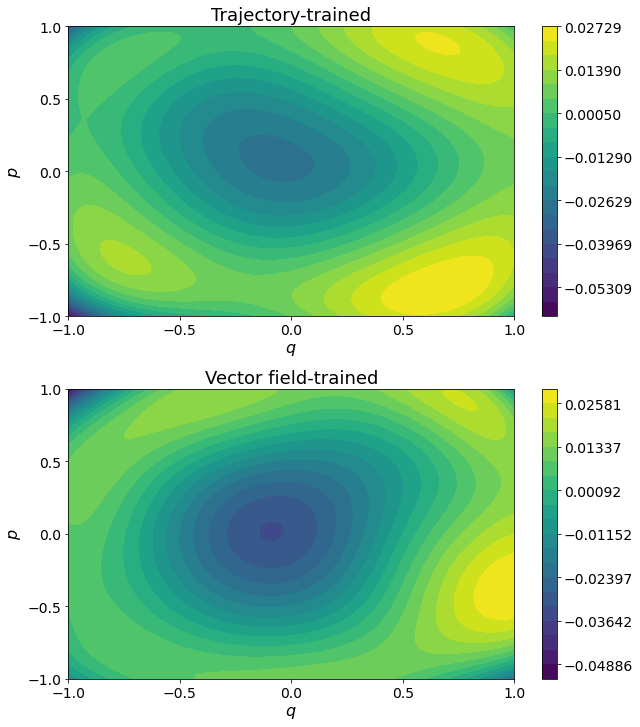

In [30]:

N_points = 301
x = np.linspace(-1.0, 1.0, N_points)
y = np.linspace(-1.0, 1.0, N_points)
X, Y = np.meshgrid(x, y)

m, k = 1.0, 1.0
H_ex_func = lambda q, p: 0.5 * p**2 / m + 0.5 * k * q**2
H_ex = H_ex_func(X, Y)

z = np.column_stack((X.flatten(), Y.flatten()))
H_traj = hrnn_traj_model.hamiltonian(torch.tensor(z).float()).detach().numpy().reshape(N_points,N_points)
H_vect = hrnn_vect_model.hamiltonian(torch.tensor(z).float()).detach().numpy().reshape(N_points,N_points)

H_diff_traj = H_traj - H_ex
H_diff_traj = H_diff_traj - np.mean(H_diff_traj)

H_diff_vect = H_vect - H_ex
H_diff_vect = H_diff_vect - np.mean(H_diff_vect)

fig, ax = plt.subplots(2, 1, figsize=(10,12))
plt.subplots_adjust(hspace=0.25)

cf1 = ax[0].contourf(X, Y, H_diff_traj, levels=np.linspace(np.amin(H_diff_traj), np.amax(H_diff_traj), 21))
cbar1 = fig.colorbar(cf1, ax=ax[0])
cbar1.ax.tick_params(labelsize=14)
ax[0].set_title("Trajectory-trained", fontsize=18)
ax[0].set_xlabel("$q$", fontsize=16)
ax[0].set_ylabel("$p$", fontsize=16)

cf2 = ax[1].contourf(X, Y, H_diff_vect, levels=np.linspace(np.amin(H_diff_vect), np.amax(H_diff_vect), 21))
cbar2 = fig.colorbar(cf2, ax=ax[1])
cbar2.ax.tick_params(labelsize=14)
ax[1].set_title("Vector field-trained", fontsize=18)
ax[1].set_xlabel("$q$", fontsize=16)
ax[1].set_ylabel("$p$", fontsize=16)

ax[0].set_xticks([-1.0, -0.5, 0.0, 0.5, 1.0]);
ax[0].set_yticks([-1.0, -0.5, 0.0, 0.5, 1.0]);
ax[0].tick_params(axis='both', which='major', labelsize=14);
ax[0].tick_params(axis='both', which='minor', labelsize=14)
ax[1].set_xticks([-1.0, -0.5, 0.0, 0.5, 1.0]);
ax[1].set_yticks([-1.0, -0.5, 0.0, 0.5, 1.0]);
ax[1].tick_params(axis='both', which='major', labelsize=14);
ax[1].tick_params(axis='both', which='minor', labelsize=14)


fig.savefig("HRNNvect-HRNNtraj/hamiltonian_contourf.png", dpi=200);


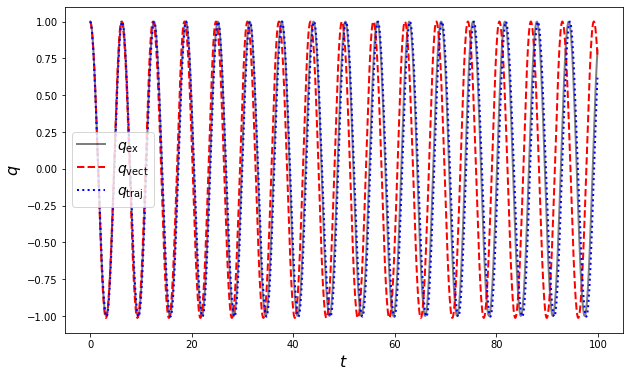

In [31]:

from IPython.display import display, HTML
display(HTML('<h1>Fixed step size</h1>'))

from tools.integrate import *

q0 = 1.0
p0 = 0.0

x0 = torch.tensor(np.array([q0, p0]).reshape(1,2)).float()

t0 = 0.0
T = 100.0
t_span = [t0, T]
t_eval = np.arange(t0, T, trajDataSet.pred_times[0], dtype=np.float32)

hrnn_traj_sol = integrate_model(hrnn_traj_model, t_eval, x0, rk_method=model_int_method)
hrnn_vect_sol = integrate_model(hrnn_vect_model, t_eval, x0, rk_method=model_int_method)


# Extract the first trajectory of our one-length initial condition batch
q_traj = hrnn_traj_sol[0,:,0].detach().numpy()
p_traj = hrnn_traj_sol[0,:,1].detach().numpy()
q_vect = hrnn_vect_sol[0,:,0].detach().numpy()
p_vect = hrnn_vect_sol[0,:,1].detach().numpy()

m, k = 1.0, 1.0
w = np.sqrt(k / m)

ex_q = lambda t: q0 * np.cos(w * t) + p0 / (m*w) * np.sin(w * t)
ex_p = lambda t: -q0 * np.sqrt(k*m)*np.sin(w * t) + p0*np.cos(w * t)

q_ex = ex_q(t_eval)
p_ex = ex_p(t_eval)

plt.figure(figsize=(10,6))

plt.plot(t_eval, q_ex, 'k-', lw=2, alpha=0.5, label="$q_\mathrm{ex}$");
plt.plot(t_eval, q_vect, 'r--', lw=2, label="$q_\mathrm{vect}$");
plt.plot(t_eval, q_traj, 'b:', lw=2, label="$q_\mathrm{traj}$");
plt.xlabel("$t$", fontsize=16);
plt.ylabel("$q$", fontsize=16);
plt.legend(fontsize=14);

plt.savefig("HRNNvect-HRNNtraj/integrated.png", dpi=200)




In [32]:
"""Saving models"""

folder = "HRNNvect-HRNNtraj"

filename = "HRNNvect"
torch.save(hrnn_vect_model.state_dict(), folder+"/"+filename+".pth")
print(f"Saved PyTorch Model State to {folder+'/'+filename}.pth")

filename = "HRNNtraj"
torch.save(hrnn_traj_model.state_dict(), folder+"/"+filename+".pth")
print(f"Saved PyTorch Model State to {folder+'/'+filename}.pth")


Saved PyTorch Model State to HRNNvect-HRNNtraj/HRNNvect.pth
Saved PyTorch Model State to HRNNvect-HRNNtraj/HRNNtraj.pth


In [ ]:
"""Loading model"""

folder = "HRNNvect-HRNNtraj"

filename = "HRNNvect"
hrnn_vect_model.load_state_dict(torch.load(folder+"/"+filename+".pth"))

filename = "HRNNtraj"
hrnn_traj_model.load_state_dict(torch.load(folder+"/"+filename+".pth"))